# Whisky Advocate
## *Insights from Reviews*

What makes a great whiskey? It is a smoky flavor? It is peaty? Is it something else?

There isn't a single truth of a great whisky, because tastes vary so much from person to person. However, we can analyze the reviews of experts to see if we can detect patterns in the flavor profiles of 'great' whiskys.

Today, you'll see the following things operationalized in python to study great whiskys:
* [Web Scraping](#web)
* [Data Exploration](#explore)
* [Machine Learning](#ml)
* [Data Visualization](#viz)


<a id="web"></a>
## Web Scraping
To gather our review data to understand great whiskeys, we will *scrape* [Whisky Advocate's](http://whiskeyadvocate.com) over 4,00 reviews. We will use python to access the reviews on the web and extract the relevant information from directly from the site's `html`.

In [1]:
import pandas as pd
import requests
from bs4 import BeautifulSoup

In [2]:
score_range = ['1-100']

In [3]:
url = "http://whiskyadvocate.com/ratings-reviews/?search=&submit=&brand_id=0&rating={}&price=0&category=0&styles_id=0&issue_id=0"

In [4]:
urls = [url.format(score) for score in score_range]

In [5]:
tags = ['ratingValue', 'name', 'category', 'priceCurrency', 
 'price', 'description', 'author']

def get_review(review):
    data = {}
    for t in tags:
        data[t] = review.find(itemprop=t).text

    return data

def whiskey(urls):
    
    whiskey_reviews = list()
    
    for u in urls:
        r = requests.get(u)
        
        soup = BeautifulSoup(r.text, "lxml")
        ratings = soup.find(class_="ratings-grid-holder")
        
        ratings = ratings.find_all("article")
        
        reviews = [get_review(r) for r in ratings]
        
        whiskey_reviews += reviews
    
    return whiskey_reviews

In [6]:
data = whiskey(urls)

In [7]:
data[0]

{'ratingValue': '97',
 'name': 'Johnnie Walker Blue Label, 40%',
 'category': 'Blended Scotch Whisky',
 'priceCurrency': '$',
 'price': '225',
 'description': "\nMagnificently powerful and intense. Caramels, dried peats, elegant cigar smoke, seeds scraped from vanilla beans, brand new pencils, peppercorn, coriander seeds, and star anise make for a deeply satisfying nosing experience. Silky caramels, bountiful fruits of ripe peach, stewed apple, orange pith, and pervasive smoke with elements of burnt tobacco. An abiding finish of smoke, dry spices, and banoffee pie sweetness. Close to perfection. Editor's Choice",
 'author': 'Jonny McCormick'}

In [8]:
df = pd.DataFrame.from_records(data)

In [9]:
df.head()

,author,category,description,name,price,priceCurrency,ratingValue
0,Jonny McCormick,Blended Scotch Whisky,\nMagnificently powerful and intense. Caramels...,"Johnnie Walker Blue Label, 40%",225,$,97
1,John Hansell,Bourbon/Tennessee,\nA marriage of 13 and 18 year old bourbons. A...,Four Roses Limited Edition Small Batch (2013 R...,85,$,97
2,John Hansell,Bourbon/Tennessee,\nThis bottling celebrates master distiller Pa...,"Parker's Heritage Collection, 'Golden Annivers...",150.00,$,97
3,John Hansell,Single Malt Scotch,\nWhat impresses me most is how this whisky ev...,"Black Bowmore 42 year old 1964 vintage, 40.5%",4500,$,97
4,Dave Broom,Single Malt Scotch,\nThere have been some legendary Bowmores from...,"Bowmore 46 year old (distilled 1964), 42.9%",13500,$,97


In [10]:
df.shape[0]

5109

In [11]:
df['ratingValue'].astype('int').describe()

count    5109.000000
mean       86.898219
std         4.548035
min        60.000000
25%        84.000000
50%        87.000000
75%        90.000000
max        97.000000
Name: ratingValue, dtype: float64

In [12]:
subset = df['category'].value_counts().index[:4].tolist()

In [13]:
df['p2'] = df['price'].astype('str').replace(",","").replace("$", "")

In [14]:
df['p2'].astype('float').describe()

ValueError: could not convert string to float: '1,500'

In [15]:
df['p2'].str.replace("$", "").str.replace("/set","").astype('float')

ValueError: could not convert string to float: '1,500'

In [16]:
df['price'] = pd.to_numeric(df['price'], errors='coerce')

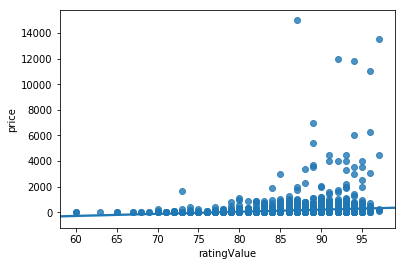

In [18]:
import seaborn as sns
from locale import atof

#df['price'] = df['price'].apply(atof)
sns.regplot(x=df[df['price'] < 20000]['ratingValue'].astype('float'), y=df[df['price'] < 20000]['price'])

In [19]:
df['pert_alcohol'] = df['name'].apply(lambda x: x.split()[-1][:-1])

In [20]:
df['pert_alcohol'] = pd.to_numeric(df['pert_alcohol'], errors='coerce')

In [22]:
def  is_it_perct(name):
    #print(name)
    last_seg = name.split()[-1]
    if last_seg[-1:] == "%":
        return last_seg[:-1]
    else:
        return None

In [206]:
df.loc[df['name'].isnull(), 'name'] = 'Bunnahabhain'

In [23]:
df['pert_alcohol'] = df['name'].apply(is_it_perct)
df['pert_alcohol'] = pd.to_numeric(df['pert_alcohol'], errors='coerce')

In [24]:
df.head()

,author,category,description,name,price,priceCurrency,ratingValue,p2,pert_alcohol
0,Jonny McCormick,Blended Scotch Whisky,\nMagnificently powerful and intense. Caramels...,"Johnnie Walker Blue Label, 40%",225.0,$,97,225,40.0
1,John Hansell,Bourbon/Tennessee,\nA marriage of 13 and 18 year old bourbons. A...,"Four Roses 2013 Limited Edition Small Batch, 5...",85.0,$,97,85,51.5
2,Dave Broom,Single Malt Scotch,\nThere have been some legendary Bowmores from...,"Bowmore 46 year old (distilled 1964), 42.9%",13500.0,$,97,13500.00,42.9
3,John Hansell,Bourbon/Tennessee,\nThis bottling celebrates master distiller Pa...,"Parker's Heritage Collection, 'Golden Annivers...",150.0,$,97,150.00,50.0
4,John Hansell,Single Malt Scotch,\nWhat impresses me most is how this whisky ev...,"Black Bowmore, 1964 vintage, 42 year old, 40.5%",4500.0,$,97,4500.00,40.5


In [25]:
df['pert_alcohol'].describe()

count    4081.000000
mean       47.513194
std         6.465042
min        17.000000
25%        43.000000
50%        46.000000
75%        50.500000
max        98.600000
Name: pert_alcohol, dtype: float64

/Users/jsokoll/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


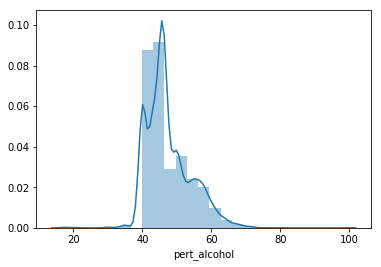

In [238]:
import seaborn as sns
sns.distplot(df[-df['pert_alcohol'].isnull()]['pert_alcohol'], bins=25)

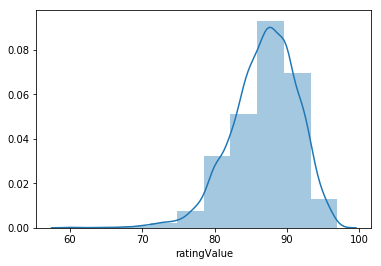

In [21]:
sns.distplot(df['ratingValue'].astype('float'), bins=10)

In [25]:
df['ratingValue'] = df['ratingValue'].astype(int)
df.head()

,author,category,description,name,price,priceCurrency,ratingValue,p2,pert_alcohol
0,Jonny McCormick,Blended Scotch Whisky,\nMagnificently powerful and intense. Caramels...,"Johnnie Walker Blue Label, 40%",225.0,$,97,225,40.0
1,John Hansell,Bourbon/Tennessee,\nA marriage of 13 and 18 year old bourbons. A...,Four Roses Limited Edition Small Batch (2013 R...,85.0,$,97,85,51.5
2,John Hansell,Bourbon/Tennessee,\nThis bottling celebrates master distiller Pa...,"Parker's Heritage Collection, 'Golden Annivers...",150.0,$,97,150.00,50.0
3,John Hansell,Single Malt Scotch,\nWhat impresses me most is how this whisky ev...,"Black Bowmore 42 year old 1964 vintage, 40.5%",4500.0,$,97,4500,40.5
4,Dave Broom,Single Malt Scotch,\nThere have been some legendary Bowmores from...,"Bowmore 46 year old (distilled 1964), 42.9%",13500.0,$,97,13500,42.9


In [26]:
conditions = [
    (df['ratingValue'] >= 95),
    (df['ratingValue'] >= 85) & (df['ratingValue'] < 95),
    (df['ratingValue'] <= 75)]

choices = [0, 1, 2]

df['ratingCategory'] = np.select(conditions, choices)


In [29]:
df = df[['description', 'ratingCategory']]

In [30]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [33]:
print(train.shape)
print(test.shape)

(4087, 2)
(1022, 2)


In [34]:
import numpy as np
sample = test.copy()
sample['ratingCategory'] = np.random.choice([0,1,2])

In [36]:
train.to_csv('train.csv', header=True, index=True, index_label='id')
test[['description']].to_csv('test.csv', header=True, index=True, index_label='id')
test[['ratingCategory']].to_csv('solution_file.csv', header=True, index=True, index_label='id')
sample[['ratingCategory']].to_csv('sample_submission.csv', header=True, index=True, index_label='id')

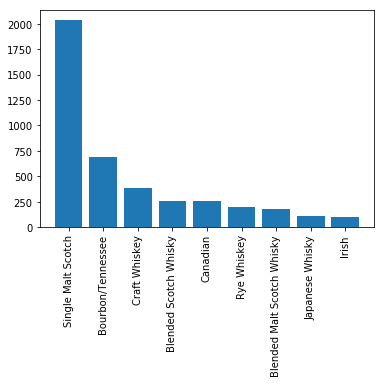

In [22]:
import numpy as np
import matplotlib.pyplot as plt

types = df['category'].value_counts()[:9]

height = types.tolist()
bars = types.index.tolist()
y_pos = np.arange(len(bars))

plt.bar(y_pos, height)
plt.xticks(y_pos, bars, rotation='vertical')

plt.show()

In [240]:
list(df)

['author',
 'category',
 'description',
 'name',
 'price',
 'priceCurrency',
 'ratingValue',
 'p2',
 'pert_alcohol']

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [23]:
desc = pd.read_csv('WhiskyFlavorDescriptors.csv', header=None)

In [8]:
desc.head()

,0
0,dignified
1,youthful
2,soft
3,firm
4,dry


In [181]:
vocab = set(desc[0])
vocab = {gram:index_ for index_, gram in enumerate(vocab)}

In [183]:
v1 = TfidfVectorizer(stop_words='english', max_features=6000, 
                       min_df=5, max_df=.8, ngram_range=(1,3))
X1 = v1.fit_transform(df['description'])

In [246]:
len(set(v1.get_feature_names()).difference(set(vocab.keys())))

5883

In [247]:
v1.transform(["peaty smokey citrus"])

<1x6000 sparse matrix of type '<class 'numpy.float64'>'
	with 2 stored elements in Compressed Sparse Row format>

In [184]:
ext_vocab = set(v1.get_feature_names()).intersection(set(vocab.keys()))
ext_vocab = {gram:index_ for index_, gram in enumerate(ext_vocab)}

In [185]:
vect = TfidfVectorizer(stop_words='english', max_features=6000, 
                       min_df=5, max_df=.8, ngram_range=(1,3),
                      vocabulary=ext_vocab, norm='l1')
X = vect.fit_transform(df['description'])

In [186]:
X.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.42342042],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [187]:
X.shape

(4159, 117)

In [188]:
vect.get_feature_names()[50:75]

['cork',
 'musty',
 'peppery',
 'balanced',
 'coal',
 'dry',
 'citric',
 'oranges',
 'aniseed',
 'shoes',
 'caramel',
 'oil',
 'apricots',
 'incense',
 'marmalade',
 'seaweed',
 'jam',
 'iodine',
 'custard',
 'mown hay',
 'coffee grounds',
 'grassy',
 'sweet',
 'ink',
 'pine nuts']

In [243]:
from sklearn.linear_model import LinearRegression

reg = LinearRegression()
reg.fit(X, df['ratingValue'].astype('float'))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [244]:
from sklearn.metrics import mean_squared_error, r2_score

y_pred = reg.predict(X)
print(r2_score(df['ratingValue'].astype('float'), y_pred))

0.16629338805488725


In [191]:
model = pd.DataFrame(reg.coef_, columns=['coef'], index=vect.get_feature_names())

In [192]:
y = df['ratingValue'].astype('float').tolist()

In [193]:
X.todense()

matrix([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.42342042],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

In [158]:
ext_vocab

{'old': 0,
 'mixing': 1,
 'citrus': 2,
 'clove': 3,
 'pick': 4,
 'mouth': 5,
 'beautifully': 6,
 'orchard fruit': 7,
 'leaving': 8,
 'lovely': 9,
 'ml': 10,
 'cooked': 11,
 'powerful': 12,
 'elegant': 13,
 'older': 14,
 'traditional': 15,
 'sherry': 16,
 'malts': 17,
 'libraries': 18,
 'leather upholstery': 19,
 'hard': 20,
 'version': 21,
 'neat': 22,
 'vintage': 23,
 'soft': 24,
 'chewy': 25,
 'anchovies': 26,
 'apples': 27,
 'slowly': 28,
 'diesel': 29,
 'mouth coating': 30,
 'wemyss': 31,
 'glazed': 32,
 'baking': 33,
 'greater': 34,
 'day': 35,
 'warming': 36,
 'pear drops': 37,
 'scented': 38,
 'marsh gas': 39,
 'green sticks': 40,
 'does': 41,
 'fresh fruit': 42,
 'vanilla': 43,
 'lots': 44,
 'peaches': 45,
 'box': 46,
 'candied': 47,
 'bright fruit': 48,
 'fragrant': 49,
 'strength': 50,
 'assertive': 51,
 'bodied': 52,
 'single barrel': 53,
 'springbank': 54,
 'll': 55,
 'lawn clippings': 56,
 'edge': 57,
 'intense': 58,
 'slight': 59,
 'raw': 60,
 'walnut': 61,
 'green tomato

In [194]:
from scipy import stats
params = np.append(reg.intercept_,reg.coef_)
predictions = y_pred
newX = pd.DataFrame({"Constant":np.ones(len(X.todense()))}).join(pd.DataFrame((X.todense())))
MSE = (sum((y-predictions)**2))/(len(newX)-len(newX.columns))

# Note if you don't want to use a DataFrame replace the two lines above with
# newX = np.append(np.ones((len(X),1)), X, axis=1)
# MSE = (sum((y-predictions)**2))/(len(newX)-len(newX[0]))

var_b = MSE*(np.linalg.inv(np.dot(newX.T,newX)).diagonal())
sd_b = np.sqrt(var_b)
ts_b = params/ sd_b

p_values =[2*(1-stats.t.cdf(np.abs(i),(len(newX)-1))) for i in ts_b]

sd_b = np.round(sd_b,3)
ts_b = np.round(ts_b,3)
p_values = np.round(p_values,3)
params = np.round(params,4)

In [196]:
from sklearn.feature_selection import f_regression
Fm, pval = f_regression(X.todense(), y)

<1x1174 sparse matrix of type '<class 'numpy.float64'>'
	with 35 stored elements in Compressed Sparse Row format>

In [165]:
newX.head()

,Constant,0,1,2,3,4,5,6,7,8,...,1164,1165,1166,1167,1168,1169,1170,1171,1172,1173
0,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0
1,1.0,1.020335,1.0,1.000000,1.0,1.0,1.0,1.0,1.042046,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0
2,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0
3,1.0,1.020092,1.0,1.011925,1.0,1.0,1.0,1.0,1.000000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.021715,1.0,1.0,1.0
4,1.0,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,1.0


In [170]:
model.sort_values(by=['coef'], ascending=False)

,coef
tcp,140.706868
kippery,96.256696
travel retail,89.796430
green leaves,89.431767
buttermilk,74.590878
lint,73.939466
powder,68.746866
spent fireworks,68.386497
medium length,68.233798
filtered,65.781572


In [197]:
model['p values'] = pval

In [198]:
model.sort_values(by=['p values', 'coef'])

,coef,p values
hot,-7.072621,2.036525e-30
sweet,-3.406847,1.993053e-18
balanced,5.972575,1.899950e-13
harsh,-21.641705,1.576740e-12
youthful,-7.410462,7.977927e-10
nutmeg,5.678638,5.107942e-09
toffee,2.170664,7.754423e-08
yeasty,-14.333041,9.832036e-08
rich,3.517390,2.057765e-07
hay,-6.647279,3.226320e-07


In [231]:
sample = model[model['p values'] <= 0.05].sort_values(by='coef')
#sample = model.sort_values(by='coef')
sample

,coef,p values
harsh,-21.6417,0.0000
spirity,-20.8048,0.0000
yeasty,-14.3330,0.0000
solvent,-12.8492,0.0003
clover honey,-9.7212,0.0262
youthful,-7.4105,0.0000
medicinal,-7.1737,0.0000
hot,-7.0726,0.0000
hay,-6.6473,0.0000
estery,-6.6261,0.0197


In [223]:
pd.options.display.float_format = '{:.4f}'.format
sample['sig'] = sample['p values'].apply(lambda x: 1 if x < 0.05 else 0)
sample.head(20)

,coef,p values,sig
harsh,-21.6417,0.0000,1
spirity,-20.8048,0.0000,1
yeasty,-14.3330,0.0000,1
solvent,-12.8492,0.0003,1
clover honey,-9.7212,0.0262,1
digestive biscuits,-7.6106,0.0520,0
youthful,-7.4105,0.0000,1
medicinal,-7.1737,0.0000,1
hot,-7.0726,0.0000,1
hay,-6.6473,0.0000,1


In [203]:
reg.intercept_

86.33397451310411

In [242]:
from bokeh.io import show, output_notebook
from bokeh.plotting import figure
from bokeh.models import HoverTool

output_notebook()

p = figure(x_range=sample.index.tolist(), plot_height=350, 
           title="Whiskey Review Words", tools='hover')
p.vbar(x=sample.index.tolist(), top=sample['coef'], width=0.8)
p.xaxis.major_label_orientation = "vertical"
hover = p.select(dict(type=HoverTool))
hover.tooltips = [('Word',' @x'), ('Coef', ' @top')]
show(p)

Loading BokehJS ...

In [230]:
df.loc[df['pert_alcohol'] <= 18, 'name']f

1378                   Kerrygold Irish Cream Liqueur, 17%
2800                               Forty Creek Cream, 17%
2988    Benjamin Prichard's Sweet Lucy Bourbon Cream L...
Name: name, dtype: object

In [192]:
df.loc[df['pert_alcohol'] == 2011, 'pert_alcohol'] = None

In [196]:
df.loc[df['pert_alcohol'] == 199, 'pert_alcohol'] = None

In [ ]:
df.loc[df['pert_alcohol']]

In [197]:
df['pert_alcohol'].describe()

count    4082.000000
mean       47.515371
std         6.466968
min        17.000000
25%        43.000000
50%        46.000000
75%        50.500000
max        98.600000
Name: pert_alcohol, dtype: float64

In [65]:
r = requests.get(urls[0])
#r = requests.get("http://whiskyadvocate.com/ratings-reviews/?search=&submit=&brand_id=0&rating=95-100&price=0&category=0&styles_id=0&issue_id=0")

In [66]:
soup = r.text

In [67]:
soup = BeautifulSoup(r.text, "lxml")

In [68]:
ratings = soup.find(class_="ratings-grid-holder")

In [69]:
ratings = ratings.find_all("article")

In [70]:
ratings[0]

<article id="post-25" itemscope="" itemtype="http://schema.org/Product" role="article">
<div class="review-top">
<h2 itemprop="aggregateRating" itemscope="" itemtype="http://schema.org/AggregateRating"><span itemprop="ratingValue">97</span> points</h2>
<div class="ratings-util cf">
<a class="email-review-btn" href="#"><span class="icon-envelope"></span></a>
<a href="/wp-content/data/shelf_talker.php?review_id=4065" target="_blank"><span class="icon-print"></span></a>
</div>
</div>
<div class="printable-section" id="review-id-1212">
<h1 itemprop="name">Johnnie Walker Blue Label, 40%</h1>
<p class="entry-meta">
<span itemprop="aggregateRating" itemscope="" itemtype="http://schema.org/AggregateRating"><span itemprop="category">Blended Scotch Whisky</span>  |  <span content="USD" itemprop="priceCurrency">$</span><span content="50.00" itemprop="price">225</span>
</span></p>
<div class="review-text" itemprop="description">
<p>Magnificently powerful and intense. Caramels, dried peats, elegant

In [27]:
tags = ['ratingValue', 'name', 'category', 'priceCurrency', 
 'price', 'description', 'author']

def get_review(review):
    data = {}
    for t in tags:
        data[t] = review.find(itemprop=t).text
    
    return data

In [58]:
whiskey = [get_review(r) for r in ratings]

In [60]:
len(whiskey)

108

In [30]:
subset

NameError: name 'subset' is not defined

In [32]:
d = df[df['category'].isin(subset)]

In [34]:
list(d)

['author',
 'category',
 'description',
 'name',
 'price',
 'priceCurrency',
 'ratingValue',
 'p2',
 'pert_alcohol']

In [38]:
d = d.drop(columns=['name','p2', 'priceCurrency'])

In [55]:
category = {'Single Malt Scotch':1,'Bourbon/Tennessee':2,'Craft Whiskey':3,'Canadian':4}

In [58]:
d.head()

,author,category,description,price,ratingValue,pert_alcohol
1,John Hansell,Bourbon/Tennessee,A marriage of 13 and 18 year old bourbons. A m...,85.0,97,51.5
2,Dave Broom,Single Malt Scotch,There have been some legendary Bowmores from t...,13500.0,97,42.9
3,John Hansell,Bourbon/Tennessee,This bottling celebrates master distiller Park...,150.0,97,50.0
4,John Hansell,Single Malt Scotch,What impresses me most is how this whisky evol...,4500.0,97,40.5
6,Davin de Kergommeaux,Canadian,"After 40 years in barrels, the trademark Canad...",199.0,96,45.0


In [62]:
d['category'] = d['category'].map(category)

In [39]:
d['description'] = d['description'].apply(lambda x: x.strip())

In [64]:
d.head()

,author,category,description,price,ratingValue,pert_alcohol
1,John Hansell,2,A marriage of 13 and 18 year old bourbons. A m...,85.0,97,51.5
2,Dave Broom,1,There have been some legendary Bowmores from t...,13500.0,97,42.9
3,John Hansell,2,This bottling celebrates master distiller Park...,150.0,97,50.0
4,John Hansell,1,What impresses me most is how this whisky evol...,4500.0,97,40.5
6,Davin de Kergommeaux,4,"After 40 years in barrels, the trademark Canad...",199.0,96,45.0


In [45]:
from sklearn.model_selection import train_test_split

In [65]:
X = d.drop(columns='category')
y = d['category']

train_x, test_x, train_y, test_y = train_test_split(X, y, stratify=y, test_size=.1)

In [67]:
test_y.value_counts()

1    183
2     50
3     33
4     22
Name: category, dtype: int64

In [68]:
train = pd.DataFrame(X)
train['category'] = train_y

In [71]:
%cd /Users/jsokoll/Desktop

/Users/jsokoll/Desktop


In [72]:
train.to_csv('train.csv',header=True,index=True,index_label='id')

In [73]:
test = pd.DataFrame(test_x)

In [155]:
test.to_csv('test.csv',header=True,index=True,index_label='id')

In [77]:
validation = pd.DataFrame({'id':test_y.index.values,'category':test_y})

In [79]:
validation.head()

,id,category
955,955,2
3532,3532,2
1390,1390,4
1024,1024,1
1902,1902,1


In [80]:
validation.to_csv('validation.csv', index=False, header=True)

In [81]:
sample = validation.copy()

In [82]:
from random import randint
sample['category'] = sample['category'].apply(lambda x: randint(1,4))

In [83]:
sample.head()

,id,category
955,955,1
3532,3532,3
1390,1390,2
1024,1024,4
1902,1902,2


In [84]:
sample.to_csv('sample_submission.csv', index=False, header=True)

In [85]:
test.head()

,author,description,price,ratingValue,pert_alcohol
955,Fred Minnick,"Think carnival aromas—the good ones, anyway—me...",36.0,90,50.0
3532,Lew Bryson,"A blend of three bourbons, between 6 and 12 ye...",90.0,82,49.3
1390,Davin de Kergommeaux,"The nose is focused on cereal, hints of fresh ...",48.0,89,45.0
1024,Gavin Smith,Swiss-based Chapter 7 released this 19 year ol...,180.0,90,55.8
1902,Gavin Smith,Valkyrie replaces the current Dark Origins exp...,71.0,87,45.9


In [87]:
train.author.value_counts()

John Hansell              992
Gavin Smith               642
Dave Broom                446
Lew Bryson                280
Davin de Kergommeaux      181
Fred Minnick              133
Jeffery Lindenmuth         90
Geoffrey Kleinman          64
Dominic Roskrow            22
Jonny McCormick            17
Susannah Skiver Barton      6
Adam Polonski               1
Name: author, dtype: int64

In [134]:
train = train[-train['category'].isna()]

In [135]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [136]:
vectorizer = TfidfVectorizer(min_df=20,
                             max_df=.85,
                             lowercase=True,
                             stop_words='english',
                             ngram_range=(1,2))

In [137]:
dtm = vectorizer.fit_transform(train['description'])

In [138]:
dtm

<2586x1128 sparse matrix of type '<class 'numpy.float64'>'
	with 86015 stored elements in Compressed Sparse Row format>

In [139]:
dtm = pd.DataFrame(dtm.todense())
dtm.columns = vectorizer.get_feature_names()
dtm = dtm.set_index(train.index)

In [151]:
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [197]:
svd = TruncatedSVD(50)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)

In [198]:
prepare = make_pipeline(vectorizer,svd,normalizer)

In [199]:
X_lsa = lsa.fit_transform(dtm)

In [201]:
lsa_df = pd.DataFrame(X_lsa)
lsa_df = lsa_df.set_index(train.index)

In [ ]:
train['ratingValue']

In [210]:
X = train[['price','pert_alcohol']].join(lsa_df)
y = train['category']

In [211]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [212]:
from xgboost import XGBClassifier

In [213]:
model = XGBClassifier()
model.fit(X_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='multi:softprob', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [214]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)

0.9180834621329211


In [215]:
X_val = vectorizer.transform(test['description'])
X_val_lsa = lsa.transform(X_val)

In [216]:
val_lsa_df = pd.DataFrame(X_val_lsa)
val_lsa_df = val_lsa_df.set_index(test.index)
X = test[['price','pert_alcohol']].join(val_lsa_df)

In [186]:
pred_test = model.predict(X)

In [189]:
sub = pd.DataFrame({'id':test.index.values,'category':pred_test})

In [191]:
sub['category'] = sub['category'].astype('int')

In [192]:
sub.head()

,id,category
0,955,2
1,3532,3
2,1390,1
3,1024,1
4,1902,1


In [193]:
sub.to_csv('submission1.csv',header=True,index=False)